# Task 4.3P - Build your own image recognition system – group task
Brenton Adey
s222165064

## Import libraries

In [80]:
import os
import shutil
import random

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import pickle

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_samples, silhouette_score, accuracy_score, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from yellowbrick.cluster import silhouette_visualizer, intercluster_distance, kelbow_visualizer

# 1. Data collection and annotation

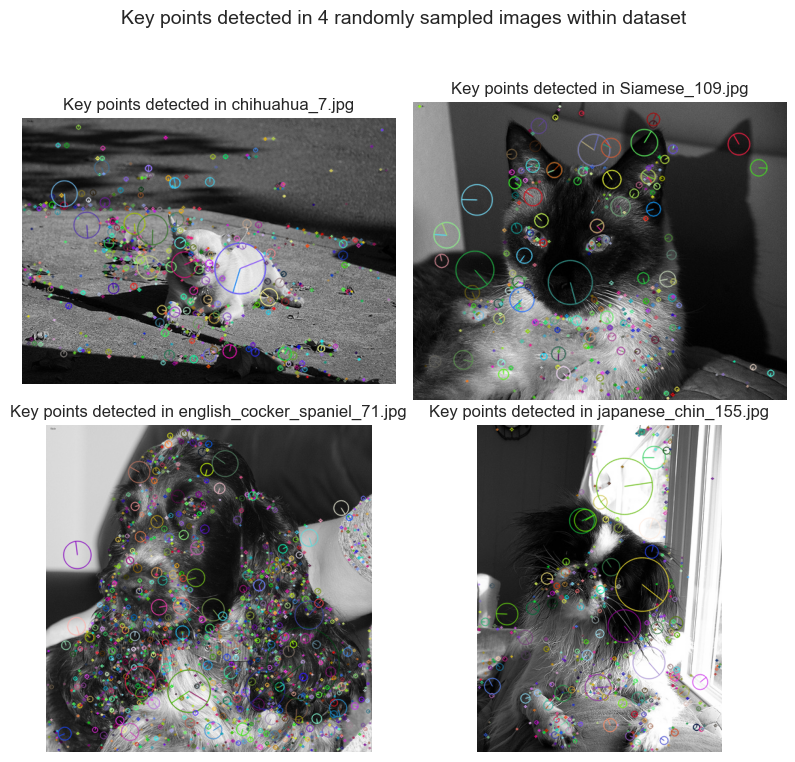

In [54]:
# Find key points of 4 random images and display to ensure that key points can be found
image_directory = './images/'
sift = cv.SIFT_create()
fig, imgs = plt.subplots(2,2)
fig.set_size_inches(8,8)

sampled_filenames = random.sample(os.listdir(image_directory), 4)
for idx, filename in enumerate(sampled_filenames):
    filepath = os.path.join(image_directory, filename)
    img = cv.imread(filepath) #load image
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp = sift.detect(img_gray, None)
    img_gray_kp = img_gray.copy()
    img_gray_kp = cv.drawKeypoints(img_gray, kp, img_gray_kp, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    index = np.unravel_index(idx,(2,2))
    imgs[index].imshow(img_gray_kp)
    imgs[index].axis('off')
    imgs[index].set_title(f"Key points detected in {filename}")


fig.suptitle("Key points detected in 4 randomly sampled images within dataset", fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# 2. Building image recognition application

## 2.1. Building BoW model (Silhouette analysis)

In [13]:
class Dictionary(object):
    def __init__(self, name, img_filenames, num_words):
        self.name = name #name of your dictionary
        self.img_filenames = img_filenames #list of image filenames
        self.num_words = num_words #the number of words
        self.training_data = [] #this is the training data required by the K-Means algorithm
        self.words = [] #list of words, which are the centroids of clusters
    
    def learn(self):
        sift = cv.SIFT_create()
        num_keypoints = [] #this is used to store the number of keypoints in each image
        #load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)
        #cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(self.num_words)
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_
        #create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            #for each file, create a histogram
            histogram = np.zeros(self.num_words, np.float32)
            #if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)
        return training_word_histograms

    def create_word_histograms(self, img_filenames):
        sift = cv.SIFT_create()
        histograms = []
        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]
            histogram = np.zeros(self.num_words, np.float32) #word histogram for the input image
            if descriptors is not None:
                for des in descriptors:
                    #find the best matching word
                    min_distance = 1111111 #this can be any large number
                    matching_word_ID = -1 #initial matching_word_ID=-1 means no matching
                    for i in range(0, self.num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i
                    histogram[matching_word_ID] += 1
                histogram /= len(descriptors) #normalise histogram to frequencies
            histograms.append(histogram)
        return histograms

In [14]:
import os

breeds = ["shiba_inu", "american_bulldog", "basset_hound", "chihuahua"]
path = 'images/'
training_file_names = []
training_breed_labels = []
for i, breed in enumerate(breeds):
    sub_path = path + 'train/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    training_file_names += sub_file_names
    training_breed_labels += sub_breed_labels

print(training_file_names)
print(training_breed_labels)

['images/train/shiba_inu_57.jpg', 'images/train/shiba_inu_80.jpg', 'images/train/shiba_inu_94.jpg', 'images/train/shiba_inu_95.jpg', 'images/train/shiba_inu_137.jpg', 'images/train/shiba_inu_68.jpg', 'images/train/shiba_inu_40.jpg', 'images/train/shiba_inu_96.jpg', 'images/train/shiba_inu_41.jpg', 'images/train/shiba_inu_108.jpg', 'images/train/shiba_inu_79.jpg', 'images/train/shiba_inu_92.jpg', 'images/train/shiba_inu_87.jpg', 'images/train/shiba_inu_93.jpg', 'images/train/shiba_inu_78.jpg', 'images/train/shiba_inu_131.jpg', 'images/train/shiba_inu_50.jpg', 'images/train/shiba_inu_133.jpg', 'images/train/shiba_inu_132.jpg', 'images/train/shiba_inu_126.jpg', 'images/train/shiba_inu_141.jpg', 'images/train/shiba_inu_20.jpg', 'images/train/shiba_inu_34.jpg', 'images/train/shiba_inu_140.jpg', 'images/train/shiba_inu_142.jpg', 'images/train/shiba_inu_181.jpg', 'images/train/shiba_inu_208.jpg', 'images/train/shiba_inu_209.jpg', 'images/train/shiba_inu_1.jpg', 'images/train/shiba_inu_22.jpg'

In [4]:
sift = cv.SIFT_create()
num_keypoints = [] #this is used to store the number of keypoints in each image
training_data = []
#load training images and compute SIFT descriptors
for filename in training_file_names:
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    list_des = sift.detectAndCompute(img_gray, None)[1]
    if list_des is None:
        num_keypoints.append(0)
    else:
        num_keypoints.append(len(list_des))
        for des in list_des:
            training_data.append(des)

training_data = np.array(training_data)

Training kMeans model with 25 clusters...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating silhouette plot...
Generating intercluster distance plot...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


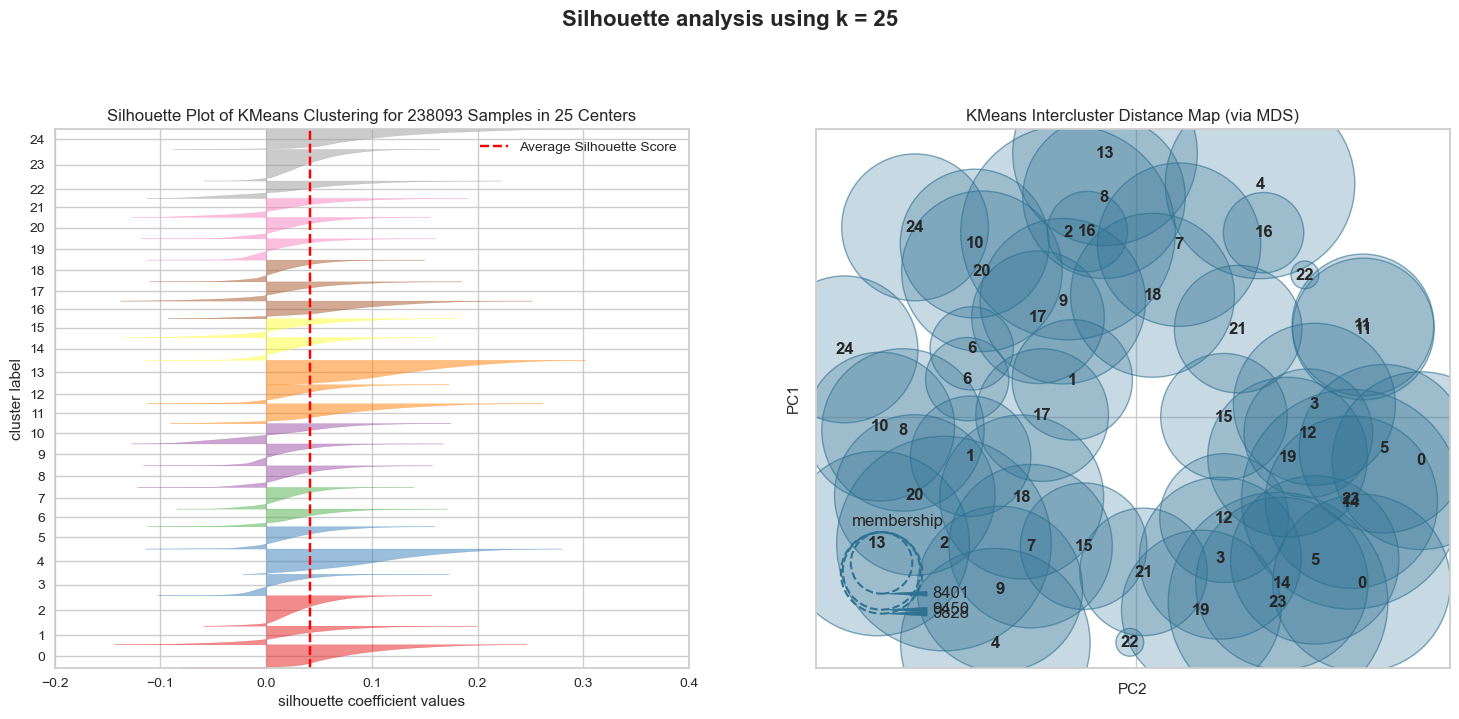

Training kMeans model with 50 clusters...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating silhouette plot...
Generating intercluster distance plot...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


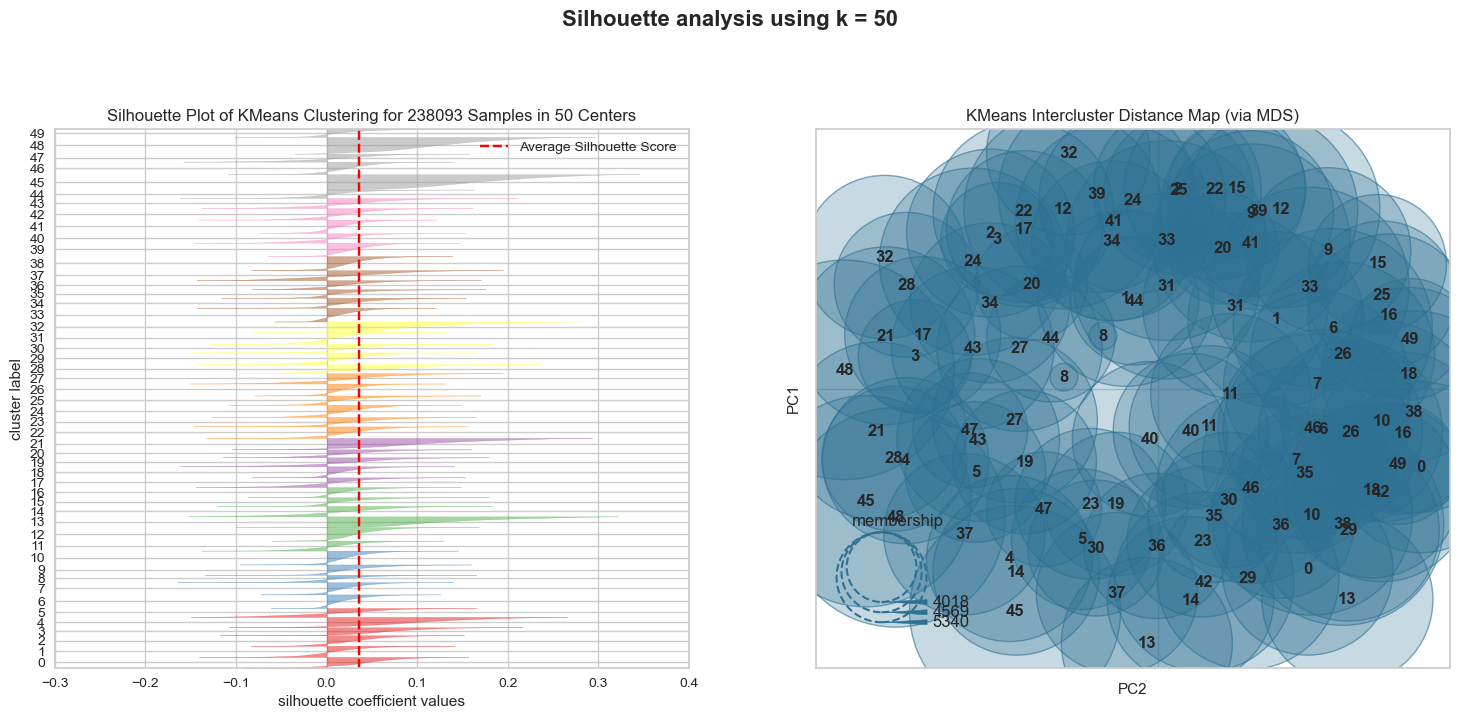

Training kMeans model with 100 clusters...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating silhouette plot...
Generating intercluster distance plot...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


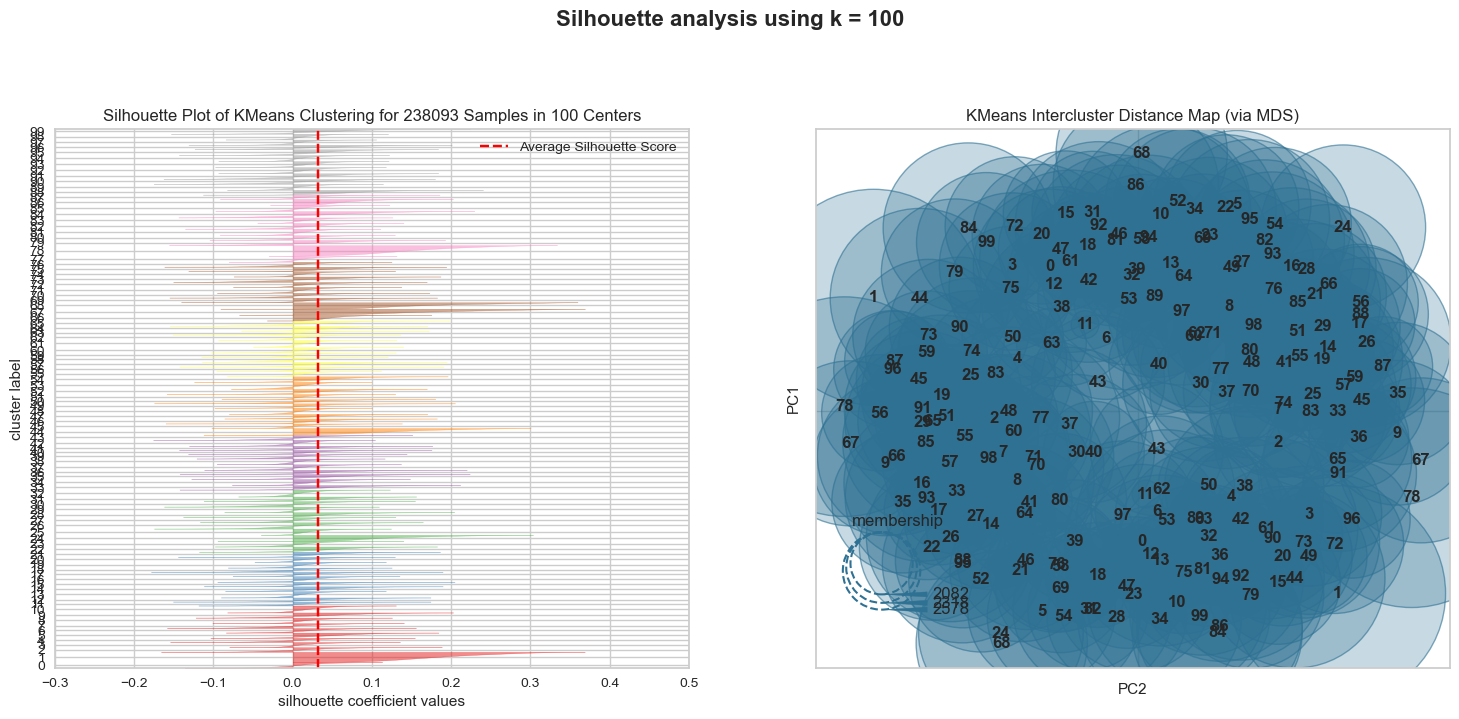

Training kMeans model with 200 clusters...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating silhouette plot...
Generating intercluster distance plot...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


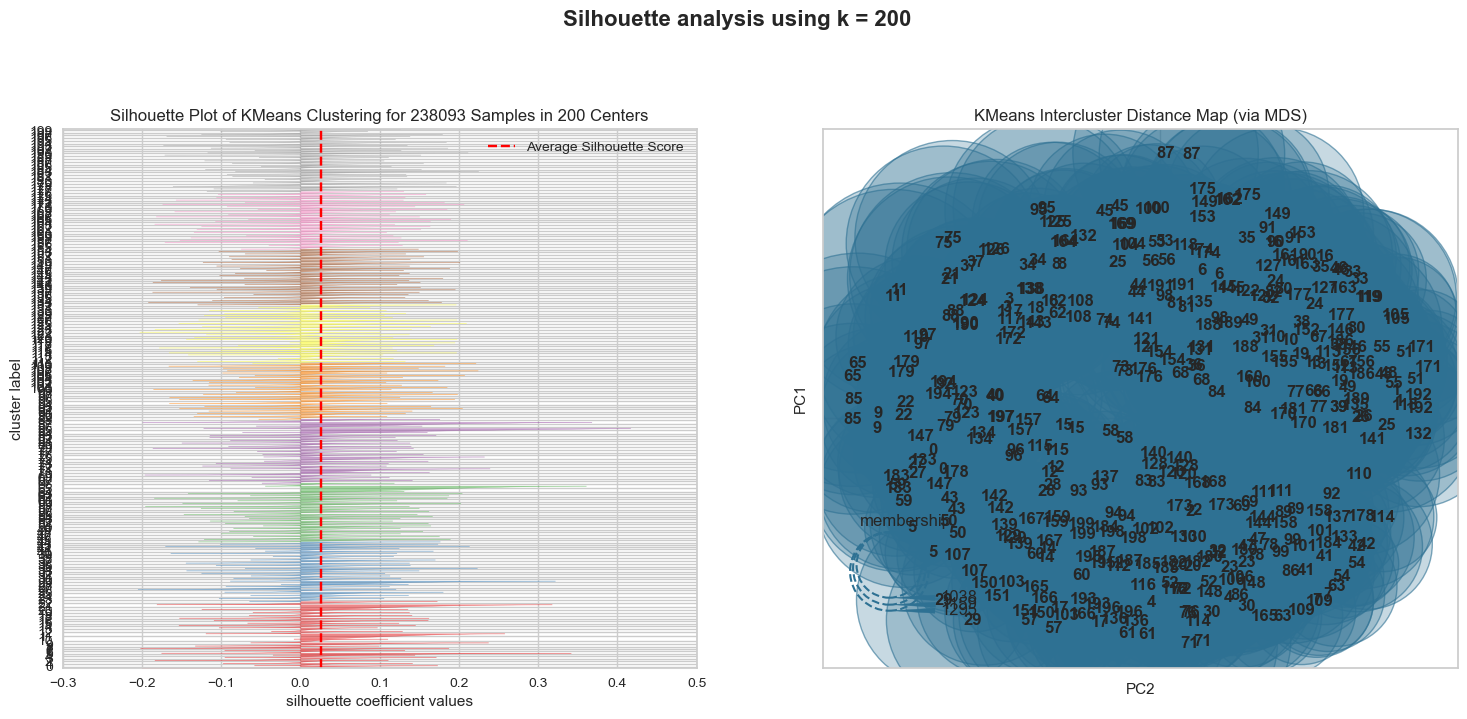

Training kMeans model with 500 clusters...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating silhouette plot...
Generating intercluster distance plot...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


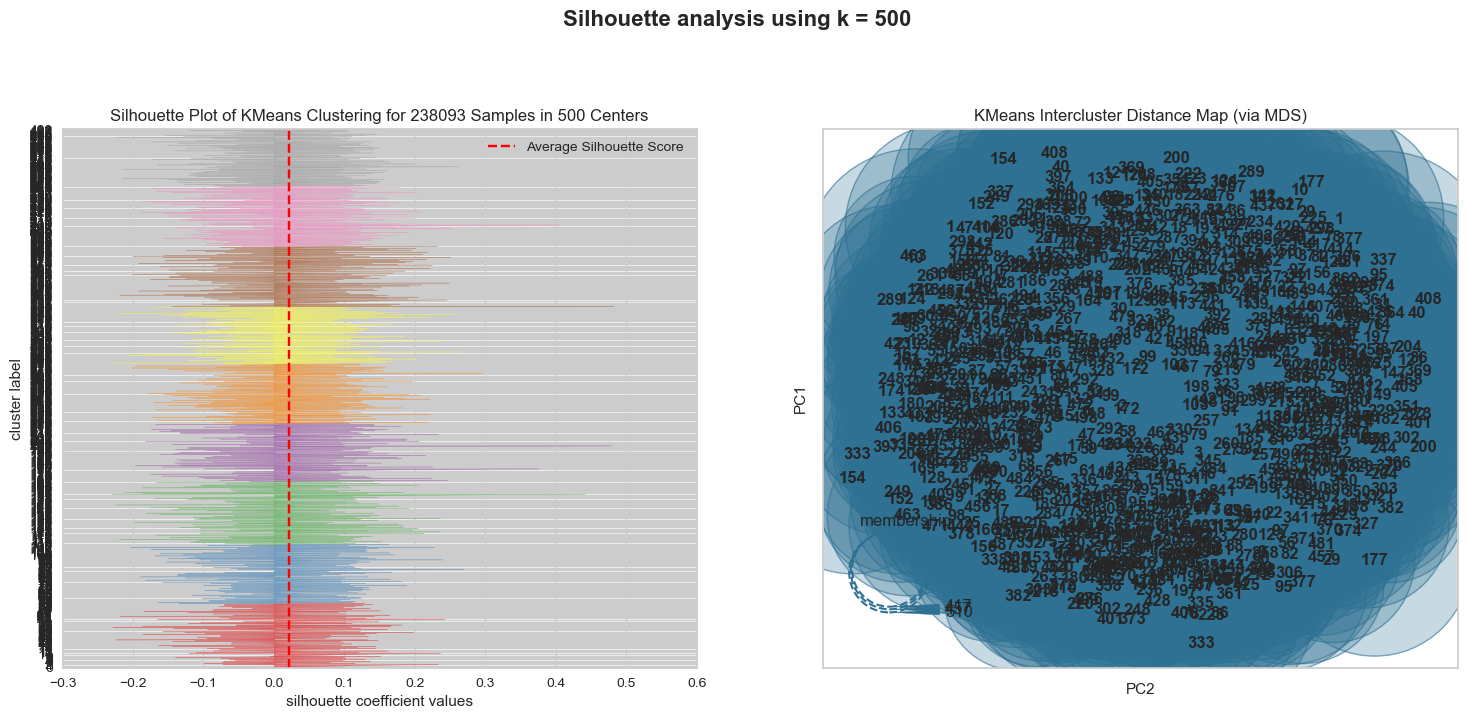

In [7]:
for i, k in enumerate([25,50,100,200,500]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    print(f"Training kMeans model with {k} clusters...")
    labels = km.fit_predict(training_data)
    
    # Silhouette plot
    print("Generating silhouette plot...")
    silhouette_vis = silhouette_visualizer(km, training_data, ax=ax1, is_fitted=True, show=False)
    
    # Scatter plot of data colored with labels
    print("Generating intercluster distance plot...")
    scatter_vis = intercluster_distance(km, training_data, ax=ax2, is_fitted=True, show=False)
    scatter_vis.fit(training_data)

    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05)
    plt.show()

/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

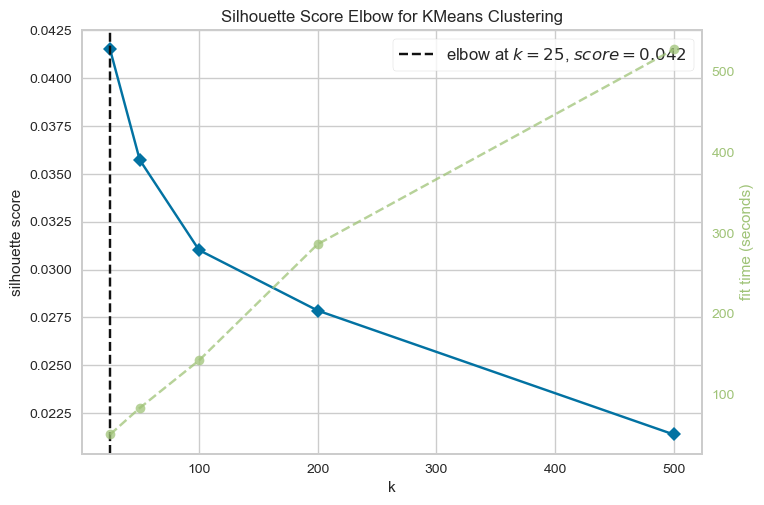

KElbowVisualizer(ax=<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=500), k=[25, 50, 100, 200, 500],
                 metric='silhouette')

In [10]:
kelbow_visualizer(KMeans(), training_data, k=[25,50,100,200,500], metric="silhouette")

## 2.2 Building classifiers

First, we will use the results from the previous section to create the dictionary of words for the training and validation dataset.

In [15]:
breeds = ["shiba_inu", "american_bulldog", "basset_hound", "chihuahua"]
path = 'images/'
training_file_names = []
training_breed_labels = []
for i, breed in enumerate(breeds):
    sub_path = path + 'train/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    training_file_names += sub_file_names
    training_breed_labels += sub_breed_labels

validation_file_names = []
validation_breed_labels = []
for i, breed in enumerate(breeds):
    sub_path = path + 'val/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    validation_file_names += sub_file_names
    validation_breed_labels += sub_breed_labels


print(training_file_names)
print(training_breed_labels)

print(validation_file_names)
print(validation_breed_labels)

['images/train/shiba_inu_57.jpg', 'images/train/shiba_inu_80.jpg', 'images/train/shiba_inu_94.jpg', 'images/train/shiba_inu_95.jpg', 'images/train/shiba_inu_137.jpg', 'images/train/shiba_inu_68.jpg', 'images/train/shiba_inu_40.jpg', 'images/train/shiba_inu_96.jpg', 'images/train/shiba_inu_41.jpg', 'images/train/shiba_inu_108.jpg', 'images/train/shiba_inu_79.jpg', 'images/train/shiba_inu_92.jpg', 'images/train/shiba_inu_87.jpg', 'images/train/shiba_inu_93.jpg', 'images/train/shiba_inu_78.jpg', 'images/train/shiba_inu_131.jpg', 'images/train/shiba_inu_50.jpg', 'images/train/shiba_inu_133.jpg', 'images/train/shiba_inu_132.jpg', 'images/train/shiba_inu_126.jpg', 'images/train/shiba_inu_141.jpg', 'images/train/shiba_inu_20.jpg', 'images/train/shiba_inu_34.jpg', 'images/train/shiba_inu_140.jpg', 'images/train/shiba_inu_142.jpg', 'images/train/shiba_inu_181.jpg', 'images/train/shiba_inu_208.jpg', 'images/train/shiba_inu_209.jpg', 'images/train/shiba_inu_1.jpg', 'images/train/shiba_inu_22.jpg'

We are now ready for building the BoW model for our food recognition problem. Suppose that we want to have 50 words in our dictionary.

In [56]:
num_words = 50
dictionary_name = 'breeds'
dictionary = Dictionary(dictionary_name, training_file_names, num_words)

We learn the dictionary, i.e., finding words, by calling the learn method as below. The learn method not only extracts words from a training dataset but also creates the word histograms for all the training images in the training set.

In [57]:
training_word_histograms = dictionary.learn()
validation_word_histograms = dictionary.create_word_histograms(validation_file_names)

/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


Since training a dictionary is time consuming, we should save the dictionary into file once the training is complete and reload it for use without retraining. To save the dictionary into file, you can use pickle as follows.

In [58]:
#save dictionary
with open('breeds_dictionary.dic', 'wb') as f: #'wb' is for binary write
    pickle.dump(dictionary, f)

### K-NN

In [59]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
nn_search_space = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

In [60]:
# Train the knn model

for n_neighbours in nn_search_space:
    knn = KNeighborsClassifier(n_neighbors = n_neighbours)
    knn.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on training dataset
    training_pred = knn.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)
    
    # Get accuracy on validation dataset
    validation_pred = knn.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

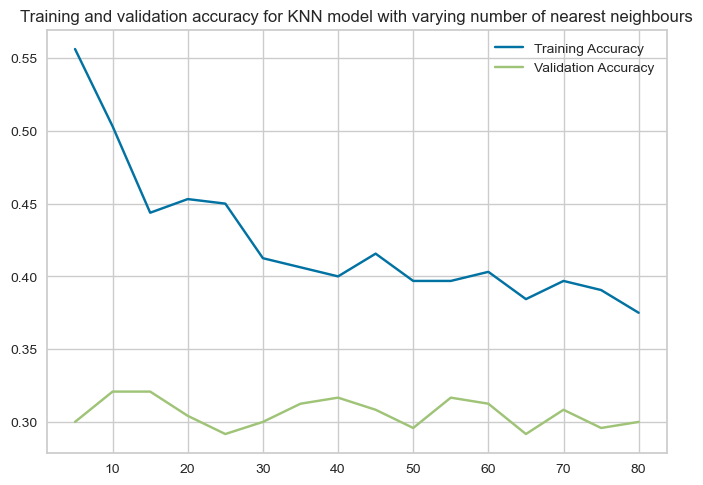

In [61]:
# Plot the results

plt.plot(nn_search_space, training_accuracies, label='Training Accuracy')
plt.plot(nn_search_space, validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.title("Training and validation accuracy for KNN model with varying number of nearest neighbours")
plt.show()

In [62]:
best_nn = nn_search_space[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The value for number of nearest neighbour with the best validation accuracy is {best_nn} with an accuracy of {best_val_acc:.2%}")

The value for number of nearest neighbour with the best validation accuracy is 10 with an accuracy of 32.08%


In [77]:
# Re-train and save best model
knn = KNeighborsClassifier(n_neighbors = best_nn)
knn.fit(training_word_histograms, training_breed_labels)
with open('best_knn.pkl', 'wb') as f: #'wb' is for binary write
    pickle.dump(knn, f)

### Random Forest

In [69]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
n_estimators_search_space = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [70]:
# Train the rf model

for n_estimators in n_estimators_search_space:
    rf = RandomForestClassifier(n_estimators= n_neighbours)
    rf.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on training dataset
    training_pred = rf.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)
    
    # Get accuracy on validation dataset
    validation_pred = rf.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

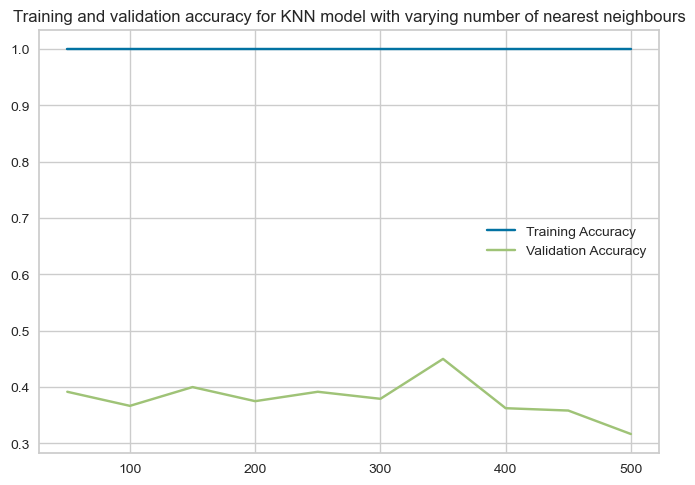

In [71]:
# Plot the results

plt.plot(n_estimators_search_space, training_accuracies, label='Training Accuracy')
plt.plot(n_estimators_search_space, validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.title("Training and validation accuracy for KNN model with varying number of nearest neighbours")
plt.show()

In [73]:
best_n_estimators = n_estimators_search_space[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The value for number of estimators with the best validation accuracy is {best_n_estimators} with an accuracy of {best_val_acc:.2%}")

The value for number of estimators with the best validation accuracy is 350 with an accuracy of 45.00%


In [78]:
# Re-train and save best model
rf = RandomForestClassifier(n_estimators= best_n_estimators)
rf.fit(training_word_histograms, training_breed_labels)
with open('best_rf.pkl', 'wb') as f: #'wb' is for binary write
    pickle.dump(rf, f)

# 2.3 Evaluating classifiers

In [74]:
# Get test file names
testing_file_names = []
testing_breed_labels = []
for i, breed in enumerate(breeds):
    sub_path = path + 'val/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    testing_file_names += sub_file_names
    testing_breed_labels += sub_breed_labels

# Generate test histograms
testing_word_histograms = dictionary.create_word_histograms(testing_file_names)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


The testing accuracy for the KNN model is 32.08%
The testing accuracy for the Random Forest model is 39.58%


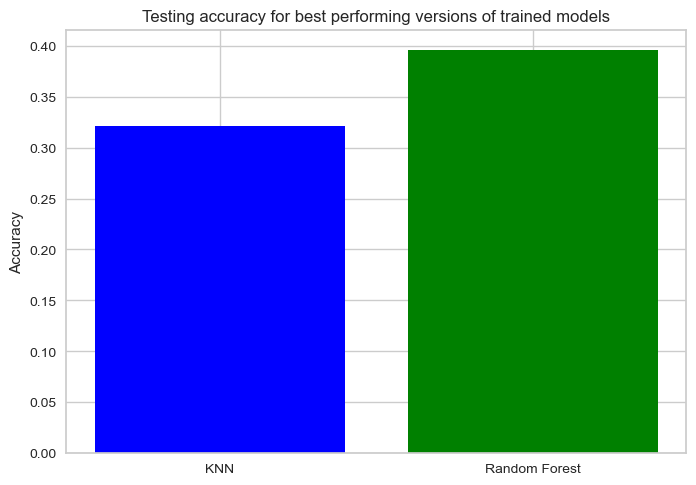

In [84]:
knn_predicted_labels = knn.predict(testing_word_histograms)
rf_predicted_labels = rf.predict(testing_word_histograms)

knn_test_acc = accuracy_score(testing_breed_labels, knn_predicted_labels)
print(f"The testing accuracy for the KNN model is {knn_test_acc:.2%}")
rf_test_acc = accuracy_score(testing_breed_labels, rf_predicted_labels)
print(f"The testing accuracy for the Random Forest model is {rf_test_acc:.2%}")

# Plot results
plt.bar(['KNN', 'Random Forest'], [knn_test_acc, rf_test_acc], color=['blue','green'])
plt.ylabel('Accuracy')
plt.title('Testing accuracy for best performing versions of trained models')
plt.show()

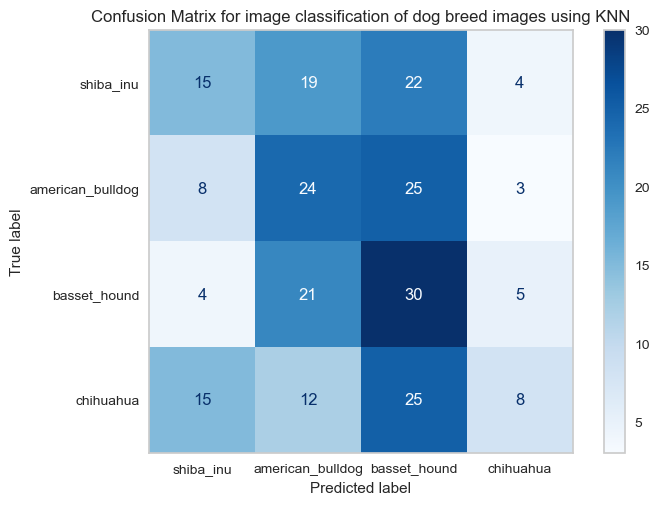

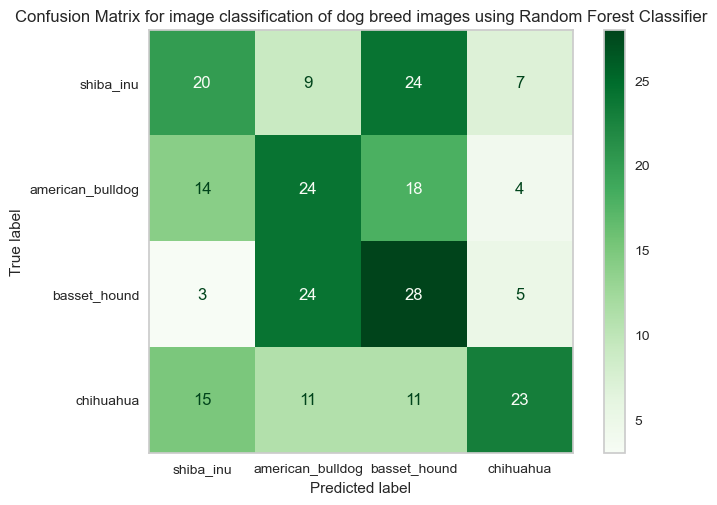

In [83]:
# Plot confusion matrices
knn_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, knn_predicted_labels, display_labels=breeds, cmap="Blues")
knn_cf_disp.ax_.set_title("Confusion Matrix for image classification of dog breed images using KNN")
plt.grid(False)
plt.show()

rf_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, rf_predicted_labels, display_labels=breeds, cmap="Greens")
rf_cf_disp.ax_.set_title("Confusion Matrix for image classification of dog breed images using Random Forest Classifier")
plt.grid(False)
plt.show()